# Thermodynamic Analysis
## Load up stuff, and read in FBA results

In [45]:
#load up everything
%matplotlib inline
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()
import escher
from escher import Builder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import cobra.test
import equilibrator_api
from equilibrator_api import Q_
from equilibrator_api import get_compound
import math
from sbtab import SBtab
from equilibrator_pathway import Pathway

network = pd.read_csv('shikimate_reactions.csv' , header=0)#shikimate related reactions to add
sinks = pd.read_csv('sinks.csv' , header=0)#sinks to add

levdopa_synthesis = cobra.io.load_json_model("e_coli_core.json")#e coli central metabolism model from BiGG
#levdopa_synthesis.solver = 'cplex'

#define intracellular reactions not in central metabolism model
for (myenzyme , mypathway , myreaction) in network.itertuples(index = False):
    rxn = Reaction(myenzyme)
    levdopa_synthesis.add_reactions([rxn])
    rxn.name = myenzyme
    rxn.subsystem = mypathway
    rxn.build_reaction_from_string(myreaction)

#define extra transport reactions not in central metabolism model
for (mymetabolite , mydirection) in sinks.itertuples(index = False):
    myreaction = '%s -->' % mymetabolite
    rxn = Reaction('EX_%s' % mymetabolite)
    levdopa_synthesis.add_reactions([rxn])
    rxn.subsystem = 'Extracellular exchange'
    rxn.name = '%s_transport' % mymetabolite
    rxn.build_reaction_from_string(myreaction)
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.

solution = pd.read_csv('FBA_results/aerobic.csv' , index_col = 0)
solution_glutamate = pd.read_csv('FBA_results/aerobic_glutamate.csv' , index_col = 0)
solution_anaerobic = pd.read_csv('FBA_results/anaerobic.csv' , index_col = 0)

unknown metabolite 'dahp_c' created
unknown metabolite 'dhq_c' created
unknown metabolite '3dhs_c' created
unknown metabolite 'shikimate_c' created
unknown metabolite 'shikimate3p_c' created
unknown metabolite 'epsp_c' created
unknown metabolite 'chorismate_c' created
unknown metabolite 'prephenate_c' created
unknown metabolite '4hppa_c' created
unknown metabolite 'tyr__L_c' created
unknown metabolite 'levdopa_c' created
unknown metabolite 'levdopa_e' created


## KEGG ID stuff
Import the *E. coli* core metabolism json and extract the metabolites section. Then, define a function that takes a BiGG metabolite ID and spits out the corresponding KEGG ID.

Also write a function that takes a reaction from the Cobra model (with our BiGG-format ID's) and turns it into a Equilibrator-readable reaction.

In [49]:
#Import e coli core model in json format
import json
with open('e_coli_core.json') as f:
    ecolicore = json.load(f)
metabolites = ecolicore['metabolites']

custom_metabolites = pd.read_csv('shikimate_metabolites.csv' , index_col = 0)

#Returns KEGG ID for a given BiGG ID
def getKEGG(met_id):
    #Search for metabolite by BiGG ID in the e coli core model
    entry = list(filter(lambda met: met['id'] == met_id, metabolites))
    #If we get a hit, return it
    try:
        return entry[0]['annotation']['kegg.compound'][0]
    #If else, it's probably one of my custom metabolites
    except:
        return custom_metabolites.at[met_id , 'KEGG_ID']
    

#Takes a reaction object and converts it into an Equilibrator-parsable string
def stringReaction(rxn , for_pathway = False):
    left = {met : stoich for met , stoich in rxn.metabolites.items() if stoich < 0}
    right = {met : stoich for met , stoich in rxn.metabolites.items() if stoich > 0}
    rxn_string = ''
    
    if not for_pathway:
        for met , stoich in left.items():
            rxn_string += '%.2f kegg:%s + ' % (-1*stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '= '
        for met , stoich in right.items():
            rxn_string += '%.2f kegg:%s + ' % (stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    else:
        #return in equilibrator pathway-happy format if you so request. (no kegg or leading 1's)
        for met , stoich in left.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (-1*stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '<=> '
        for met , stoich in right.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    return(rxn_string)
        

## dGo and dGm Helper Function

This function queries equilibrator for all reactions in a flux vector, inverting the sign of the resulting dG if the corresponding flux is negative. It can find either dGo or dGm. Results are returned as a dataframe of the value and error for each reaction. Transport and exchange reactions are ignored!

In [50]:
#Gets delta go or delta gm for each reaction in a data frame
def getG(flux_df , useGm = False):
    #this will store the string form g values and the indices in parallel arrays
    g = []
    indices = []
    #iterate over every reaction that isn't an exchange or transport
    for rxn in flux_df.index:
        if rxn.rfind('EX_') < 0 and rxn.rfind('_t') < 0 and rxn != 'H2Ot' and rxn != 'NH4t' and rxn != 'CO2t' and rxn != 'O2t':
            #flip the signs of reactions with negative fluxes
            if flux_df.loc[rxn , 'fluxes'] < 0:
                flip_sign = -1
            else:
                flip_sign = 1
            try:
                #make equilibrator model of reaction
                s = stringReaction(levdopa_synthesis.reactions.get_by_id(rxn))
                reaction = equilibrator_api.parse_reaction_formula(s)
                cc = equilibrator_api.ComponentContribution(p_h=Q_(7.0), temperature=Q_("298.15K"))
                # calculate standard free energy
                if not useGm:
                    g.append(flip_sign * cc.standard_dg_prime(reaction))
                #calculate metabolic free energy
                else:
                    g.append(flip_sign * cc.physiological_dg_prime(reaction))
            except:
                print('Failed to add reaction %s' % rxn)
                g.append(None)
            indices.append(rxn)
    #extract magnitudes and errors from string form g
    magnitudes = []
    errors = []
    for a in g:
        if a is None:
            magnitudes.append(None)
            errors.append(None)
        else:
            magnitudes.append(float(str(a.magnitude)[0:str(a.magnitude).rfind('+')]))
            errors.append(float(str(a.magnitude)[str(a.magnitude).rfind('-')+1:]))
    #return result as data frame
    if useGm:
        cols = ['dGm_kJ_per_mol' , 'error']
    else:
        cols = ['dGo_kJ_per_mol' , 'error']
    result = pd.DataFrame(zip(magnitudes , errors) , index = indices , columns = cols)
    return result
    

## Overall Pathway Thermodynamics of FBA Solutions

Use the `getG()` function above to calculate the dGm for each step in our flux solutions. Then, for each flux solution, multiply each reaction's dGm (kJ/mol) by its pathway's relative flux (mol/arbitrary time unit, assumed to be mol/min for this) and sum to get the overall dGm of the reaction.

Normalize these by the flux of L-DOPA synthesis to get a result in units of kJ/mol L-DOPA synthesized so that we can compare across flux solutions!

In [51]:
#Aerobic solution
print('Aerobic Solution')
Gm = getG(solution , useGm = True)
nonspontaneous = Gm.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous = Gm.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')

dGm_overall = 0
for index , row in Gm.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall += row['dGm_kJ_per_mol'] * abs(solution.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall) / abs(solution.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution
Total dGm of flux vector: -8914.160311 kJ/min
Normalized to L-DOPA production: -1753.961105 kJ/mol L-DOPA


In [52]:
#Aerobic + glutamate solution
print('Aerobic Solution with Glutamate Feed')
Gm_glu = getG(solution_glutamate , useGm = True)
nonspontaneous_glu = Gm_glu.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous_glu = Gm_glu.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')

dGm_overall_glu = 0
for index , row in Gm_glu.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall_glu += row['dGm_kJ_per_mol'] * abs(solution_glutamate.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall_glu)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall_glu) / abs(solution_glutamate.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution with Glutamate Feed
Total dGm of flux vector: -300393.690217 kJ/min
Normalized to L-DOPA production: -1945.246601 kJ/mol L-DOPA


## Max-Min Driving Force
First, we need to convert into the kinds of CSV files that the Equilibrator sbtab converter requires.

In [63]:
#Export solution as an Equilibrator Pathway-compatible CSV file
def makeCSV(flux_df , filename):
    reaction_names = [stringReaction(levdopa_synthesis.reactions.get_by_id(rxn) , for_pathway = True) for rxn in flux_df.index]
    result = pd.DataFrame(zip(reaction_names , flux_df.fluxes.values), columns = ['ReactionFormula' , 'RelativeFlux'])
    result.to_csv('Equilibrator_Pathway_CSV/%s' % filename , index = False)
#Run this function for the shikimate pathway. Only put in the rows that aren't sinks or passive transports.
shikimate_rxns = [r.name for r in levdopa_synthesis.reactions if r.subsystem == 'shikimate_pathway' or r.subsystem == 'tyrosine_metabolism']
shikimate_fluxes = solution.loc[shikimate_rxns,'fluxes'] / solution.loc['hpaBC','fluxes']
shikimate_rxns = pd.DataFrame(shikimate_fluxes.values , index = shikimate_rxns , columns = ['fluxes'])
#Only worry about the NADH-dependent shikimate dehydrogenase for this analysis.
shikimate_rxns = shikimate_rxns.drop(['shikimate_dh'])
shikimate_rxns.at['shikimate_dh_nadh','fluxes'] = 1
makeCSV(shikimate_rxns , 'shikimate.csv')
#Make CSV files for the aerobic and aerobic+glutamate FBA solutions (scrub out sinks and passive transports)
exchange_reactions = ['EX_for_e','EX_pi_e','PIt2r','EX_co2_e','FORti','EX_glc__D_e','EX_h_e','EX_h2o_e','EX_nh4_e','EX_o2_e','CO2t','NH4t','H2Ot','O2t','levdopa_t','EX_levdopa_e','EX_glu__L_e','GLUt2r']
makeCSV(solution.query('not index in @exchange_reactions')  , 'solution.csv')
makeCSV(solution_glutamate.query('not index in @exchange_reactions')  , 'solution_glutamate.csv')

*__brief detour to the equilibrator website to make an `sbtab`__*

Make the following modifications to the output b/c equilibrator is silly:
* change the 'RelativeFluxes' table to 'Fluxes'
* change the columns 'Concentrations!Min' and 'Concentrations!Max' to 'Min' and 'Max'
* ensure there are no forward and reverse duplicates of the same reaction (looking at you, ATP synthase!)

-15.976842528819088 kilojoule / mole


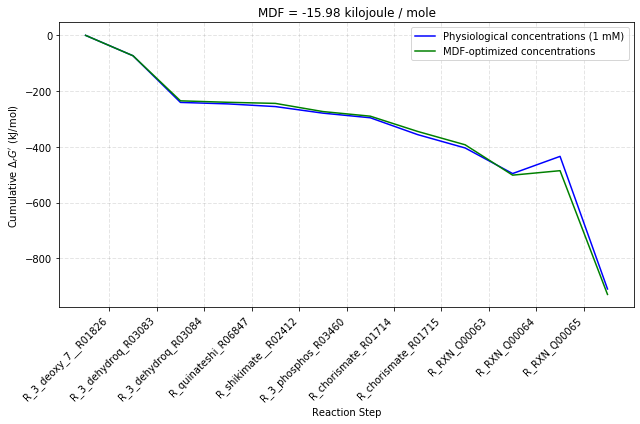

In [69]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/shikimate_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("shikimate_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
shikimate_pathway = Pathway.from_sbtab(doc)
shikimate_mdf_result = shikimate_pathway.calc_mdf()
#Plot output
shikimate_mdf_result.reaction_plot;

In [83]:
shikimate_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = False)

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
9,R_RXN_Q00064,"Compound(id=827, inchi_key=QAIPRVGONGVQAS-DUXP...",1.0 millimolar / second,61.61640928807518 kilojoule / mole,61.61640928807518 kilojoule / mole,15.976842528819088 kilojoule / mole,1.000000e+00
3,R_quinateshi_R06847,"Compound(id=13, inchi_key=BOPGDPNILDQYTO-NNYOX...",1.0 millimolar / second,-9.608647138494256 kilojoule / mole,-9.608647138494256 kilojoule / mole,-3.9037012935872446 kilojoule / mole,-2.131822e-16
2,R_3_dehydroq_R03084,"Compound(id=456, inchi_key=WVMWZWGZRAXUBK-SYTV...",1.0 millimolar / second,-5.290204863241644 kilojoule / mole,-5.290204863241644 kilojoule / mole,-5.290204863241644 kilojoule / mole,0.000000e+00
5,R_3_phosphos_R03460,"Compound(id=70, inchi_key=DTBNBXWJWCWCIK-UHFFF...",1.0 millimolar / second,-16.582596184099152 kilojoule / mole,-16.582596184099152 kilojoule / mole,-16.582596184099152 kilojoule / mole,0.000000e+00
4,R_shikimate__R02412,"Compound(id=6, inchi_key=ZKHQWZAMYRWXGA-KQYNXX...",1.0 millimolar / second,-23.535582752598216 kilojoule / mole,-23.535582752598216 kilojoule / mole,-29.240528597505225 kilojoule / mole,0.000000e+00
7,R_chorismate_R01715,"Compound(id=319, inchi_key=WTFXTQVDAKGDEY-HTQZ...",1.0 millimolar / second,-47.84913782567853 kilojoule / mole,-47.84913782567853 kilojoule / mole,-47.84913782567853 kilojoule / mole,0.000000e+00
6,R_chorismate_R01714,"Compound(id=1247, inchi_key=QUTYKIXIUDQOLK-PRJ...",1.0 millimolar / second,-43.3833539611398 kilojoule / mole,-60.49819149586082 kilojoule / mole,-54.793245650953814 kilojoule / mole,0.000000e+00
0,R_3_deoxy_7__R01826,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",1.0 millimolar / second,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,0.000000e+00
8,R_RXN_Q00063,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",1.0 millimolar / second,-74.6149471383424 kilojoule / mole,-91.72978467306342 kilojoule / mole,-108.84462220778445 kilojoule / mole,0.000000e+00
1,R_3_dehydroq_R03083,"Compound(id=1126, inchi_key=PJWIPEXIFFQAQZ-PUF...",1.0 millimolar / second,-150.2757188641873 kilojoule / mole,-167.39055639890833 kilojoule / mole,-161.6856105540013 kilojoule / mole,0.000000e+00


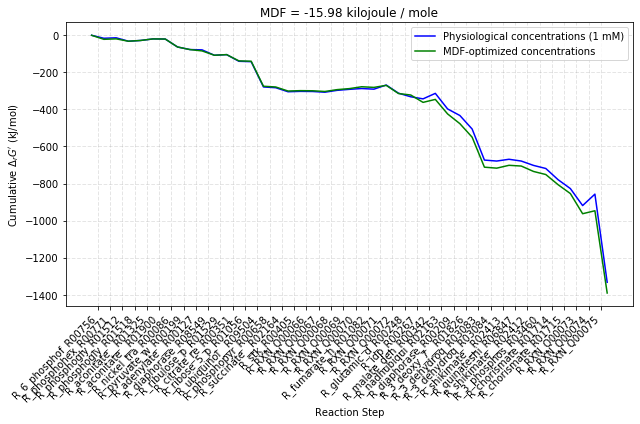

In [68]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/solution_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
solution_pathway = Pathway.from_sbtab(doc)
solution_mdf_result = solution_pathway.calc_mdf()
#Plot output
solution_mdf_result.reaction_plot;

In [82]:
solution_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = False).query('optimized_dg_prime > 0')

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
27,R_malate_deh_R00342,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",3.058992806 millimolar / second,29.665838593927084 kilojoule / mole,29.665838593927084 kilojoule / mole,15.976842528819104 kilojoule / mole,3.347214e-16
40,R_RXN_Q00074,"Compound(id=827, inchi_key=QAIPRVGONGVQAS-DUXP...",5.082302158 millimolar / second,61.61640928807518 kilojoule / mole,61.61640928807518 kilojoule / mole,15.976842528819088 kilojoule / mole,1.000000e+00
33,R_shikimate__R02413,"Compound(id=9, inchi_key=ACFIXJIJDZMPPO-NNYOXO...",-2.023309353 millimolar / second,9.619773270316877 kilojoule / mole,9.619773270316877 kilojoule / mole,15.32471911522389 kilojoule / mole,0.000000e+00
23,R_RXN_Q00071,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",13.22359712 millimolar / second,5.233896006863752 kilojoule / mole,22.34873354158478 kilojoule / mole,10.938841851770764 kilojoule / mole,0.000000e+00
21,R_RXN_Q00070,"Compound(id=396, inchi_key=RNBGYGVWRKECFJ-VRPW...",8.305899281 millimolar / second,21.442038364088244 kilojoule / mole,4.3272008293672135 kilojoule / mole,10.032146674274225 kilojoule / mole,0.000000e+00
19,R_RXN_Q00068,"Compound(id=176, inchi_key=FNZLKVNUWIIPSJ-RFZP...",-3.388201439 millimolar / second,10.025766454187083 kilojoule / mole,10.025766454187083 kilojoule / mole,10.025766454187089 kilojoule / mole,1.443741e-16
4,R_aconitate__R01325,"Compound(id=123, inchi_key=KRKNYBCHXYNGOX-UHFF...",3.058992806 millimolar / second,8.324533500572423 kilojoule / mole,8.324533500572423 kilojoule / mole,8.324533500572423 kilojoule / mole,0.000000e+00
20,R_RXN_Q00069,"Compound(id=74, inchi_key=GNGACRATGGDKBX-UHFFF...",8.305899281 millimolar / second,5.485501104913026 kilojoule / mole,5.485501104913026 kilojoule / mole,5.485501104913026 kilojoule / mole,0.000000e+00
3,R_phosphogly_R01518,"Compound(id=261, inchi_key=GXIURPTVHJPJLF-UWTA...",-13.22359712 millimolar / second,4.1884166314404405 kilojoule / mole,4.1884166314404405 kilojoule / mole,4.1884166314404405 kilojoule / mole,0.000000e+00
10,R_ribulose_p_R01529,"Compound(id=137, inchi_key=FNZLKVNUWIIPSJ-UHNV...",-1.694100719 millimolar / second,3.3656939966265327 kilojoule / mole,3.3656939966265327 kilojoule / mole,3.3656939966265327 kilojoule / mole,0.000000e+00


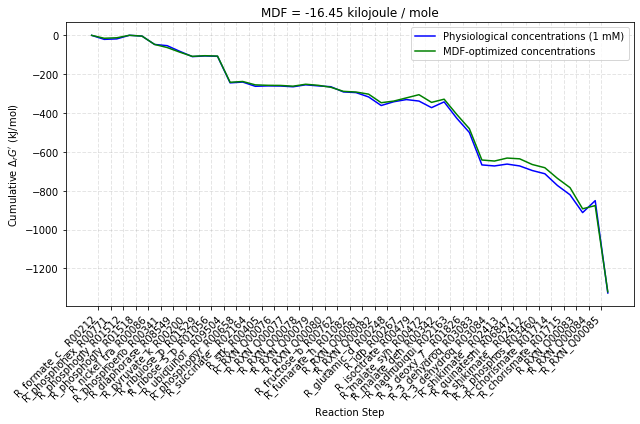

In [67]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/solution_glutamate_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_glutamate_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
solution_glu_pathway = Pathway.from_sbtab(doc)
solution_glu_mdf_result = solution_glu_pathway.calc_mdf()
#Plot output
solution_glu_mdf_result.reaction_plot;

In [81]:
solution_glu_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = False).query('optimized_dg_prime > 0')

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
27,R_malate_deh_R00342,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",978.9930348 millimolar / second,29.665838593927084 kilojoule / mole,29.665838593927084 kilojoule / mole,16.445493943832783 kilojoule / mole,0.000000e+00
39,R_RXN_Q00084,"Compound(id=827, inchi_key=QAIPRVGONGVQAS-DUXP...",154.4244776 millimolar / second,61.61640928807518 kilojoule / mole,61.61640928807518 kilojoule / mole,16.44549394383278 kilojoule / mole,5.000000e-01
24,R_idp_R00267,"Compound(id=8, inchi_key=XJLXINKUBYWONI-NNYOXO...",-484.2447761 millimolar / second,-5.905638020781567 kilojoule / mole,11.209199513939463 kilojoule / mole,16.445493943832773 kilojoule / mole,5.000000e-01
25,R_isocitrate_R00479,"Compound(id=74392, inchi_key=ODBLHEXUDAPZAU-UH...",484.2447761 millimolar / second,9.420781153067109 kilojoule / mole,-7.6940563816539225 kilojoule / mole,16.445493943832773 kilojoule / mole,-5.854915e-17
32,R_shikimate__R02413,"Compound(id=9, inchi_key=ACFIXJIJDZMPPO-NNYOXO...",-143.920995 millimolar / second,9.619773270316877 kilojoule / mole,9.619773270316877 kilojoule / mole,15.324719115223898 kilojoule / mole,0.000000e+00
2,R_phosphogly_R01512,"Compound(id=6, inchi_key=ZKHQWZAMYRWXGA-KQYNXX...",185.8993035 millimolar / second,18.50164514567255 kilojoule / mole,18.50164514567255 kilojoule / mole,12.796699300765534 kilojoule / mole,0.000000e+00
16,R_RXN_Q00078,"Compound(id=176, inchi_key=FNZLKVNUWIIPSJ-RFZP...",-102.9496517 millimolar / second,10.025766454187083 kilojoule / mole,10.025766454187083 kilojoule / mole,10.025766454187083 kilojoule / mole,0.000000e+00
23,R_glutamic_d_R00248,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",340.3237811 millimolar / second,36.46554894363627 kilojoule / mole,19.35071140891524 kilojoule / mole,8.409471134114924 kilojoule / mole,0.000000e+00
11,R_phosphopyr_R00658,"Compound(id=261, inchi_key=GXIURPTVHJPJLF-UWTA...",-185.8993035 millimolar / second,4.085902336476765 kilojoule / mole,4.085902336476765 kilojoule / mole,4.085902336476765 kilojoule / mole,-9.876892e-17
8,R_ribulose_p_R01529,"Compound(id=137, inchi_key=FNZLKVNUWIIPSJ-UHNV...",-51.47482587 millimolar / second,3.3656939966265327 kilojoule / mole,3.3656939966265327 kilojoule / mole,3.3656939966265327 kilojoule / mole,0.000000e+00
